# nbeats seq2seq 'Yearly' 적합 모델 예제

####  밑의 소스코드를 활용한 seq2seq yearly 모델 구현예제
- 다른 계절성 패턴과 lookback, loss 함수등의 여러 앙상블은 구현하지 않은 단편 모델
- 데이터 구현 : https://github.com/ServiceNow/N-BEATS/tree/master
- 모델 아키텍쳐 : https://github.com/philipperemy/n-beats


---

In [449]:
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

## m4data

In [451]:

import logging
import os
import pathlib
import sys
from urllib import request

def download(url: str, file_path: str) -> None:
    """
    Download a file to the given path.

    :param url: URL to download
    :param file_path: Where to download the content.
    """

    def progress(count, block_size, total_size):
        progress_pct = float(count * block_size) / float(total_size) * 100.0
        sys.stdout.write('\rDownloading {} to {} {:.1f}%'.format(url, file_path, progress_pct))
        sys.stdout.flush()

    if not os.path.isfile(file_path):
        opener = request.build_opener()
        opener.addheaders = [('User-agent', 'Mozilla/5.0')]
        request.install_opener(opener)
        pathlib.Path(os.path.dirname(file_path)).mkdir(parents=True, exist_ok=True)
        f, _ = request.urlretrieve(url, file_path, progress)
        sys.stdout.write('\n')
        sys.stdout.flush()
        file_info = os.stat(f)
        logging.info(f'Successfully downloaded {os.path.basename(file_path)} {file_info.st_size} bytes.')
    else:
        file_info = os.stat(file_path)
        logging.info(f'File already exists: {file_path} {file_info.st_size} bytes.')


def url_file_name(url: str) -> str:
    """
    Extract file name from url.

    :param url: URL to extract file name from.
    :return: File name.
    """
    return url.split('/')[-1] if len(url) > 0 else ''
"""
M4 Dataset
"""
import logging
import os
from collections import OrderedDict
from dataclasses import dataclass
from glob import glob

import numpy as np
import pandas as pd
#import patoolib
from tqdm import tqdm

#from common.http_utils import download, url_file_name
#from common.settings import DATASETS_PATH


STORAGE=os.getenv('STORAGE')
DATASETS_PATH=os.path.join(STORAGE, 'datasets')
EXPERIMENTS_PATH=os.path.join(STORAGE, 'experiments')
TESTS_STORAGE_PATH=os.path.join(STORAGE, 'test')
FREQUENCIES = ['Hourly', 'Daily', 'Weekly', 'Monthly', 'Quarterly', 'Yearly']
URL_TEMPLATE = 'https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/{}/{}-{}.csv'

TRAINING_DATASET_URLS = [URL_TEMPLATE.format("Train", freq, "train") for freq in FREQUENCIES]
TEST_DATASET_URLS = [URL_TEMPLATE.format("Test", freq, "test") for freq in FREQUENCIES]
INFO_URL = 'https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/M4-info.csv'
NAIVE2_FORECAST_URL = 'https://github.com/M4Competition/M4-methods/raw/master/Point%20Forecasts/submission-Naive2.rar'

DATASET_PATH = os.path.join(DATASETS_PATH, 'm4')

TRAINING_DATASET_FILE_PATHS = [os.path.join(DATASET_PATH, url_file_name(url)) for url in TRAINING_DATASET_URLS]
TEST_DATASET_FILE_PATHS = [os.path.join(DATASET_PATH, url_file_name(url)) for url in TEST_DATASET_URLS]
INFO_FILE_PATH = os.path.join(DATASET_PATH, url_file_name(INFO_URL))
NAIVE2_FORECAST_FILE_PATH = os.path.join(DATASET_PATH, 'submission-Naive2.csv')


TRAINING_DATASET_CACHE_FILE_PATH = os.path.join(DATASET_PATH, 'training.npz')
TEST_DATASET_CACHE_FILE_PATH = os.path.join(DATASET_PATH, 'test.npz')


@dataclass()
class M4Dataset:
    ids: np.ndarray
    groups: np.ndarray
    frequencies: np.ndarray
    horizons: np.ndarray
    values: np.ndarray

    @staticmethod
    def load(training: bool = True) -> 'M4Dataset':
        """
        Load cached dataset.

        :param training: Load training part if training is True, test part otherwise.
        """
        m4_info = pd.read_csv(INFO_FILE_PATH)
        return M4Dataset(ids=m4_info.M4id.values,
                         groups=m4_info.SP.values,
                         frequencies=m4_info.Frequency.values,
                         horizons=m4_info.Horizon.values,
                         values=np.load(
                             TRAINING_DATASET_CACHE_FILE_PATH if training else TEST_DATASET_CACHE_FILE_PATH,
                             allow_pickle=True))

    @staticmethod
    def download() -> None:
        """
        Download M4 dataset if doesn't exist.
        """
        if os.path.isdir(DATASET_PATH):
            logging.info(f'skip: {DATASET_PATH} directory already exists.')
            return

        download(INFO_URL, INFO_FILE_PATH)
        m4_ids = pd.read_csv(INFO_FILE_PATH).M4id.values

        def build_cache(files: str, cache_path: str) -> None:
            timeseries_dict = OrderedDict(list(zip(m4_ids, [[]] * len(m4_ids))))
            logging.info(f'Caching {files}')
            for train_csv in tqdm(glob(os.path.join(DATASET_PATH, files))):
                dataset = pd.read_csv(train_csv)
                dataset.set_index(dataset.columns[0], inplace=True)
                for m4id, row in dataset.iterrows():
                    values = row.values
                    timeseries_dict[m4id] = values[~np.isnan(values)]
            np.array(list(timeseries_dict.values())).dump(cache_path)

        for url, path in zip(TRAINING_DATASET_URLS, TRAINING_DATASET_FILE_PATHS):
            download(url, path)
        build_cache('*-train.csv', TRAINING_DATASET_CACHE_FILE_PATH)

        for url, path in zip(TEST_DATASET_URLS, TEST_DATASET_FILE_PATHS):
            download(url, path)
        build_cache('*-test.csv', TEST_DATASET_CACHE_FILE_PATH)

        naive2_archive = os.path.join(DATASET_PATH, url_file_name(NAIVE2_FORECAST_URL))
        download(NAIVE2_FORECAST_URL, naive2_archive)
        patoolib.extract_archive(naive2_archive, outdir=DATASET_PATH)


@dataclass()
class M4Meta:
    seasonal_patterns = ['Yearly', 'Quarterly', 'Monthly', 'Weekly', 'Daily', 'Hourly']
    horizons = [6, 8, 18, 13, 14, 48]
    frequencies = [1, 4, 12, 1, 1, 24]
    horizons_map = {
        'Yearly': 6,
        'Quarterly': 8,
        'Monthly': 18,
        'Weekly': 13,
        'Daily': 14,
        'Hourly': 48
    }
    frequency_map = {
        'Yearly': 1,
        'Quarterly': 4,
        'Monthly': 12,
        'Weekly': 1,
        'Daily': 1,
        'Hourly': 24
    }

def load_m4_info() -> pd.DataFrame:
    """
    Load M4Info file.

    :return: Pandas DataFrame of M4Info.
    """
    return pd.read_csv(INFO_FILE_PATH)

In [452]:
train = M4Dataset.load(training=True)
test = M4Dataset.load(training=False)

---

## data 전처리

In [453]:
def group_values(values: np.ndarray, groups: np.ndarray, group_name: str) -> np.ndarray:
    """
    Filter values array by group indices and clean it from NaNs.

    :param values: Values to filter.
    :param groups: Timeseries groups.
    :param group_name: Group name to filter by.
    :return: Filtered and cleaned timeseries.
    """
    return [v[~np.isnan(v)] for v in values[groups == group_name]]

In [454]:
M4Meta.seasonal_patterns

['Yearly', 'Quarterly', 'Monthly', 'Weekly', 'Daily', 'Hourly']

In [455]:
# 계절성분별로 m4데이터 리스트로 분할
group_train= [group_values(train.values, train.groups, M4Meta.seasonal_patterns[i]) for i in range(len(M4Meta.seasonal_patterns))]
group_test= [group_values(test.values, test.groups, M4Meta.seasonal_patterns[i]) for i in range(len(M4Meta.seasonal_patterns))]

In [456]:
"""
Timeseries sampler
"""
import numpy as np

#import gin

#@gin.configurable
class TimeseriesSampler:
    def __init__(self,
                 timeseries: np.ndarray,
                 insample_size: int,
                 outsample_size: int,
                 window_sampling_limit: int,
                 batch_size: int = 1024):
        """
        Timeseries sampler.

        :param timeseries: Timeseries data to sample from. Shape: timeseries, timesteps
        :param insample_size: Insample window size. If timeseries is shorter then it will be 0-padded and masked.
        :param outsample_size: Outsample window size. If timeseries is shorter then it will be 0-padded and masked.
        :param window_sampling_limit: Size of history the sampler should use.
        :param batch_size: Number of sampled windows.
        """
        self.timeseries = [ts for ts in timeseries]
        self.window_sampling_limit = window_sampling_limit
        self.batch_size = batch_size
        self.insample_size = insample_size
        self.outsample_size = outsample_size

    def __iter__(self):
        """
        Batches of sampled windows.

        :return: Batches of:
         Insample: "batch size, insample size"
         Insample mask: "batch size, insample size"
         Outsample: "batch size, outsample size"
         Outsample mask: "batch size, outsample size"
        """
        while True:
            insample = np.zeros((self.batch_size, self.insample_size))
            insample_mask = np.zeros((self.batch_size, self.insample_size))
            outsample = np.zeros((self.batch_size, self.outsample_size))
            outsample_mask = np.zeros((self.batch_size, self.outsample_size))
            sampled_ts_indices = np.random.randint(len(self.timeseries), size=self.batch_size)
            for i, sampled_index in enumerate(sampled_ts_indices):
                sampled_timeseries = self.timeseries[sampled_index]
                cut_point = np.random.randint(low=max(1, len(sampled_timeseries) - self.window_sampling_limit),
                                              high=len(sampled_timeseries),
                                              size=1)[0]

                insample_window = sampled_timeseries[max(0, cut_point - self.insample_size):cut_point]
                insample[i, -len(insample_window):] = insample_window
                insample_mask[i, -len(insample_window):] = 1.0
                outsample_window = sampled_timeseries[
                                   cut_point:min(len(sampled_timeseries), cut_point + self.outsample_size)]
                outsample[i, :len(outsample_window)] = outsample_window
                outsample_mask[i, :len(outsample_window)] = 1.0
            yield insample, insample_mask, outsample, outsample_mask

    def last_insample_window(self):
        """
        The last window of insample size of all timeseries.
        This function does not support batching and does not reshuffle timeseries.

        :return: Last insample window of all timeseries. Shape "timeseries, insample size"
        """
        insample = np.zeros((len(self.timeseries), self.insample_size))
        insample_mask = np.zeros((len(self.timeseries), self.insample_size))
        for i, ts in enumerate(self.timeseries):
            ts_last_window = ts[-self.insample_size:]
            insample[i, -len(ts):] = ts_last_window
            insample_mask[i, -len(ts):] = 1.0
        return insample, insample_mask

In [457]:
# group_train[0] -> 년간 시계열
train_x =TimeseriesSampler(group_train[0],10,3,1)
test_y =TimeseriesSampler(group_test[0],10,3,1)

In [458]:
# X의 인풋사이즈 설정
# data의 길이가 인풋사이즈보다 작을때 문제점있음
lookback = np.array([2,3,4,5,6,7])
horizon = M4Meta.horizons_map['Yearly']
inputsize = lookback[0]*horizon
inputsize

12

In [499]:
X = np.array([train_x.timeseries[i][-inputsize:] for i in range(len(train_x.timeseries))])
y = np.array([test_y.timeseries[i] for i in range(len(test_y.timeseries))])

In [460]:
X.shape ,y.shape

((23000, 12), (23000, 6))

In [580]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
#minmax.transform(X)
#minmax.transform(y)
xy= np.concatenate([X,y],axis=1)
minmax.fit(xy)
scale_xy = minmax.transform(xy)
X_scale,y_scale = scale_xy[:,:12], scale_xy[:,12:]

X_scale.shape, y_scale.shape

((23000, 12), (23000, 6))

## target data

- 대한민국 전력데이터 : 13년부터 20년 전력수요량

In [465]:
num= [20,21,22,23]
df = [pd.read_csv('C:\\Users\\default.DESKTOP-2ISHQBS\\lab\\task1\\demand{}.csv'.format(num[i]), encoding='cp949') for i in range(len(num))]
train_set = pd.concat([df[0],df[1]],axis=0)
vaild_set = df[2]
test_set=df[3]

train_set.shape, vaild_set.shape,test_set.shape

((3287, 25), (365, 25), (365, 25))

In [466]:
class sample:
    #####################################################################################
    ### 데이터프레임, 날짜 입력
    ### 
    def __init__(self,df,str):
        self.df = df
        self.date= df[str]
        self.date=pd.to_datetime(self.date)
    def monthly(self):    
    #####################################################################################
    ### 시간별 데이터 -> 월별 데이터로
    ### 인덱스 : 년/월, 변수 : y        
        self.train = pd.DataFrame({'date':self.date,'y':self.df.iloc[:,1:].sum(axis=1).values})
        self.train = self.train.groupby(self.train['date'].dt.to_period('M')).sum(numeric_only=True)
        #self.index= self.df.index
        #self.sample = pd.DataFrame(self.df.sum(axis=1))
        #self.sample.columns = ['y']
        return self.train

In [467]:
target_train =sample(train_set,'날짜')
target_vaild =sample(vaild_set,'날짜')
target_test =sample(test_set,'날짜')

In [468]:
class WINdow:
    def __init__(self,df,timestep):
        self.df = df
        self.timestep=timestep+1 # 예상한 timestep보다 1적기 때문에 +1
        
    def window(self):
        for i in range(1, self.timestep):
            df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
            df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
        window_df = df.dropna(axis=0) # 결측치 공간 제거
        self.window_df = window_df.iloc[:,::-1] # 좌우 반전
        
                
        self.feature= self.window_df.iloc[:,:-1].values
        self.y_label= self.window_df.iloc[:,-1].values
        
        return self. window_df

In [469]:
df = target_train.monthly()
df_val = target_vaild.monthly()
df_test = target_test.monthly()

In [577]:
target.window().iloc[:,:-1]/10000

,shift_18,shift_17,shift_16,shift_15,shift_14,shift_13,shift_12,shift_11,shift_10,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1
date,,,,,,,,,,,,,,,,,,
2014-07,4814.6417,4102.1035,4312.4632,4030.2921,3977.3910,4013.8415,4400.9912,4473.6826,3840.7957,4084.9274,4258.2416,4695.9676,4686.7424,4177.9631,4425.1754,4039.1497,4054.0187,4055.0669
2014-08,4102.1035,4312.4632,4030.2921,3977.3910,4013.8415,4400.9912,4473.6826,3840.7957,4084.9274,4258.2416,4695.9676,4686.7424,4177.9631,4425.1754,4039.1497,4054.0187,4055.0669,4503.0640
2014-09,4312.4632,4030.2921,3977.3910,4013.8415,4400.9912,4473.6826,3840.7957,4084.9274,4258.2416,4695.9676,4686.7424,4177.9631,4425.1754,4039.1497,4054.0187,4055.0669,4503.0640,4263.7237
2014-10,4030.2921,3977.3910,4013.8415,4400.9912,4473.6826,3840.7957,4084.9274,4258.2416,4695.9676,4686.7424,4177.9631,4425.1754,4039.1497,4054.0187,4055.0669,4503.0640,4263.7237,3954.4689
2014-11,3977.3910,4013.8415,4400.9912,4473.6826,3840.7957,4084.9274,4258.2416,4695.9676,4686.7424,4177.9631,4425.1754,4039.1497,4054.0187,4055.0669,4503.0640,4263.7237,3954.4689,4140.5542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,4527.6997,4465.5247,4053.0244,3996.8136,4224.9774,4556.3568,4983.3200,4342.9122,4213.0747,4390.1883,5053.3085,5199.3772,4357.0927,4545.2646,4178.1923,4254.7971,4406.4646,5246.1675
2021-09,4465.5247,4053.0244,3996.8136,4224.9774,4556.3568,4983.3200,4342.9122,4213.0747,4390.1883,5053.3085,5199.3772,4357.0927,4545.2646,4178.1923,4254.7971,4406.4646,5246.1675,5032.0938
2021-10,4053.0244,3996.8136,4224.9774,4556.3568,4983.3200,4342.9122,4213.0747,4390.1883,5053.3085,5199.3772,4357.0927,4545.2646,4178.1923,4254.7971,4406.4646,5246.1675,5032.0938,4401.5322


In [664]:
target=WINdow(df,18)
#minmax2 = MinMaxScaler()
target_scale = minmax.transform(target.window().iloc[:,:-1]/1000)

target_X = target_scale[:,:12]
target_y = target_scale[:,12:]
target_X.shape, target_y.shape 

C:\Users\default.DESKTOP-2ISHQBS\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


((90, 12), (90, 6))

In [665]:
target_X

array([[0.66445291, 0.56075288, 0.56606393, ..., 0.36961826, 0.37702059,
        0.405564  ],
       [0.56601971, 0.58957204, 0.52893078, ..., 0.38536121, 0.41586339,
        0.40476557],
       [0.59507974, 0.55091476, 0.5219691 , ..., 0.42512195, 0.41504477,
        0.36073143],
       ...,
       [0.55923971, 0.54632822, 0.55455097, ..., 0.47084905, 0.38579241,
        0.39252087],
       [0.5514745 , 0.57758654, 0.59815984, ..., 0.39434033, 0.40249035,
        0.36075127],
       [0.58299406, 0.62298533, 0.65434734, ..., 0.41143288, 0.3699172 ,
        0.36738131]])

In [666]:
target_scale_X = target_X # minmax.fit_transform(target_X)
target_scale_y =target_y #minmax.fit_transform(target_y)

In [667]:
target_scale_X_train= target_scale_X[:-18,:] 
target_scale_y_train= target_scale_y[:-18,:] 

target_scale_X_test=target_scale_X[[-1],:] 
target_scale_y_test=target_scale_y[[-1],:] 

---

## nbeats 모델 구현
- **하이퍼파라미터는 최대한 논문과 유사하게 설정**
- 앙상블은 아직 진행하지 않음
- yearly에대한 단편적인 예측 모형
- 단 데이터에 대한 scaling은 진행하였음

In [656]:
input_dim, output_dim =  1, 1
backcast=inputsize
forecast = M4Meta.horizons_map['Yearly']

K.clear_session()
model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(2,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer )

In [657]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
#checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
#model.save('best_model.h9')
history = model.fit(X_scale,y_scale,
                    epochs=50, batch_size=128,
                    callbacks=[early_stop])

Epoch 1/50
180/180 [==============================] - 11s 55ms/step - loss: 3.3383e-04
Epoch 2/50
180/180 [==============================] - 10s 55ms/step - loss: 1.4758e-04
Epoch 3/50
180/180 [==============================] - 10s 55ms/step - loss: 1.4492e-04
Epoch 4/50
180/180 [==============================] - 10s 55ms/step - loss: 1.4556e-04
Epoch 5/50
180/180 [==============================] - 10s 55ms/step - loss: 1.4311e-04
Epoch 6/50
180/180 [==============================] - 10s 54ms/step - loss: 1.3967e-04
Epoch 7/50
180/180 [==============================] - 10s 54ms/step - loss: 1.3933e-04
Epoch 8/50
180/180 [==============================] - 10s 55ms/step - loss: 1.3433e-04
Epoch 9/50
180/180 [==============================] - 10s 55ms/step - loss: 1.3539e-04
Epoch 10/50
180/180 [==============================] - 10s 54ms/step - loss: 1.3752e-04
Epoch 11/50
180/180 [==============================] - 10s 54ms/step - loss: 1.3544e-04
Epoch 12/50
180/180 [====================

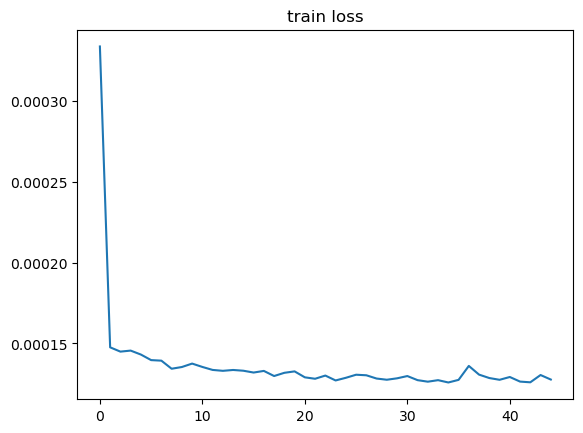

In [658]:
plt.plot(history.history['loss'])
plt.title('train loss')
plt.show()

---
## transfer learning

In [481]:
from keras.layers import *

In [ ]:
X_scale = X_scale.reshape(X_scale.shape[0], X_scale.shape[1], 1)

In [659]:
backcast_length = 12
theta_dim1, theta_dim2 = 64,6
forecast_length = 6
unit=128

In [668]:

K.clear_session()
for layer in model.layers:
    layer.trainable = True

pretrained_layers = model.layers[:-1]
pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


input1 = Input(shape=(backcast_length,1))
pretrained_output = pretrained_model(input1)
pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
lstm_output = LSTM(64, return_sequences=True)(pretrained_output_reshaped )
#concatenated_output = Concatenate()([pretrained_output_reshaped, lstm_output])

# Dense layer
dense_output = TimeDistributed(Dense(1))(lstm_output )

model_combined = Model(inputs=input1, outputs=dense_output)
model_combined.compile(loss='mse', optimizer='adam')
model_combined.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 model (Functional)          (None, 6)                 104192    
                                                                 
 reshape (Reshape)           (None, 6, 1)              0         
                                                                 
 lstm (LSTM)                 (None, 6, 64)             16896     
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             65        
 ibuted)                                                         
                                                                 
Total params: 121,153
Trainable params: 121,153
Non-trainable params: 0
_____________________________________________________

In [669]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
history2 = model_combined.fit(target_scale_X_train,target_scale_y_train,
                             epochs=50, batch_size=2,
                             callbacks=[early_stop])

Epoch 1/50
36/36 [==============================] - 5s 16ms/step - loss: 0.0473
Epoch 2/50
36/36 [==============================] - 1s 16ms/step - loss: 0.0021
Epoch 3/50
36/36 [==============================] - 1s 16ms/step - loss: 9.8126e-04
Epoch 4/50
36/36 [==============================] - 1s 16ms/step - loss: 7.8163e-04
Epoch 5/50
36/36 [==============================] - 1s 16ms/step - loss: 6.5866e-04
Epoch 6/50
36/36 [==============================] - 1s 16ms/step - loss: 6.3205e-04
Epoch 7/50
36/36 [==============================] - 1s 16ms/step - loss: 6.6001e-04
Epoch 8/50
36/36 [==============================] - 1s 16ms/step - loss: 6.1951e-04
Epoch 9/50
36/36 [==============================] - 1s 16ms/step - loss: 6.0230e-04
Epoch 10/50
36/36 [==============================] - 1s 16ms/step - loss: 5.8659e-04
Epoch 11/50
36/36 [==============================] - 1s 16ms/step - loss: 6.3502e-04
Epoch 12/50
36/36 [==============================] - 1s 16ms/step - loss: 5.2025e-

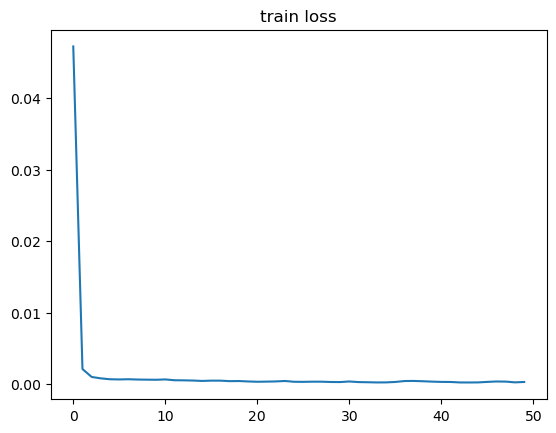

In [670]:
plt.plot(history2.history['loss'])
plt.title('train loss')
plt.show()

In [671]:
pred =model_combined.predict(target_scale_X_test)

1/1 [==============================] - 1s 645ms/step


## 비교

In [485]:
target_scale_X_train.shape,target_scale_y_train.shape

((72, 12), (72, 6))

In [673]:
K.clear_session()
modelnon0 = Sequential() # Sequeatial Model
modelnon0.add(LSTM(128, return_sequences=False,input_shape=(12, 1)))# (timestep, feature)
modelnon0.add(Dense(6)) # output = 1
modelnon0.compile(loss='mse', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )
modelnon0.fit(target_scale_X_train,target_scale_y_train, epochs=50,
          batch_size=2, verbose=0, callbacks=[early_stop])


Epoch 21: early stopping


In [674]:
pred2=modelnon0.predict(target_scale_X_test)

1/1 [==============================] - 0s 272ms/step


In [679]:
input_dim, output_dim =  1, 1
backcast=inputsize
forecast = M4Meta.horizons_map['Yearly']

K.clear_session()
model2= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK
                                                      ,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(2,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
optimizer = Adam(learning_rate=0.001)
model2.compile(loss='mse', optimizer=optimizer )
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
#model.save('best_model.h9')
history = model2.fit(target_scale_X_train,target_scale_y_train, verbose=0,
                    epochs=50, batch_size=128,
                    callbacks=[early_stop])

In [680]:
pred3 = model2.predict(target_scale_X_test)

1/1 [==============================] - 0s 378ms/step


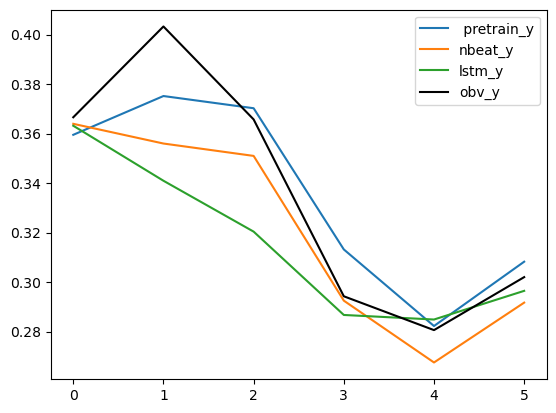

In [681]:
plt.plot(pred.flatten(),label=' pretrain_y') 
plt.plot(pred3.flatten(),label='nbeat_y') 
plt.plot(pred2.flatten(),label='lstm_y') 
plt.plot(target_scale_y_test.flatten(),label='obv_y',color='black')
plt.legend()
plt.show()

In [682]:
from sklearn.metrics import *
print('pretrain_mse',mean_squared_error(target_scale_y_test.flatten(),pred.flatten()))
print('lstm___mse',mean_squared_error(target_scale_y_test.flatten(),pred2.flatten()))
print('nbeats_mse',mean_squared_error(target_scale_y_test.flatten(),pred3.flatten()))
print('pretrain_mape',mean_absolute_percentage_error(target_scale_y_test.flatten(),pred.flatten()))
print('lstm___mape',mean_absolute_percentage_error(target_scale_y_test.flatten(),pred2.flatten()))
print('nbeats_mape',mean_absolute_percentage_error(target_scale_y_test.flatten(),pred3.flatten()))
print('pretrain_mape',mean_squared_log_error(target_scale_y_test.flatten(),pred.flatten()))
print('lstm___msle',mean_squared_log_error(target_scale_y_test.flatten(),pred2.flatten()))
print('nbeats_mape',mean_squared_log_error(target_scale_y_test.flatten(),pred3.flatten()))

pretrain_mse 0.00021004185671147268
lstm___mse 0.0010097006827473087
nbeats_mse 0.0004568734381782059
pretrain_mape 0.032038924558871494
lstm___mape 0.05785390598178753
nbeats_mape 0.04191874826178848
pretrain_mape 0.00011374103578151407
lstm___msle 0.0005456420132313409
nbeats_mape 0.00024453495229312844
